In [1]:
import pandas as pd
import numpy as np
import os, sys

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
DATA_PATH = '../data/ml-latest-small'

In [4]:
links_df = pd.read_csv(os.path.join(DATA_PATH, 'links.csv'))

In [5]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
import requests
from bs4 import BeautifulSoup
from threading import Thread

In [7]:
%%timeit 
string = 'The quick brown fox jusmps over the lazy dog'
l_w = ['brown', 'jusmps']
for i in l_w:
    string = string.replace(i, ' ')

457 ns ± 5.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [170]:
string = 'The quick brown fox jusmps over the lazy dog'
l_w = ['brown', 'jusmps']
s1 = string.replace('brown', '').replace('jusmps', '')

In [8]:
import re

In [171]:
string = 'The quick brown fox jusmps over the lazy dog'
prohibitedWords = ['brown', 'jusmps']
big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
s2 = big_regex.sub("", string)

In [9]:
prohibitedWords = ['\n', '  ']

In [10]:
class QuoteGetter(Thread):
    def __init__(self, id):
        super().__init__()
        self.id = id
        
    def run(self):
        base = 'https://www.imdb.com/title/tt0{}/'
        r = requests.get(base.format(self.id))
        soup = BeautifulSoup(r.content, "lxml")
        try:
            self.quote = (re
                          .compile('|'.join(map(re.escape, prohibitedWords)))
                          .sub("", soup
                               .find('div', {'class': "summary_text"})
                               .get_text())
                         )
        except:
            self.quote = ''

In [11]:
def get_quotes(ids):
    threads = [QuoteGetter(i) for i in ids]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    quotes = dict(zip(ids, [thread.quote for thread in threads]))
    return quotes

In [216]:
ids = list(links_df.imdbId[:1000])

In [217]:
description = get_quotes(ids)

In [584]:
def id2descripion(id):
    r = requests.get('https://www.imdb.com/title/tt0{}/'.format(id))
    page = BeautifulSoup(r.content, "html.parser")
    # short desscription
    ##text = page.find('div', {'class': "summary_text"}).text
    # StoryLine
    text = page.find('div', {'class': "inline canwrap"}).text
    return text

In [61]:
%%timeit
id = 113041
id2descripion(id)

664 ms ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
r = requests.get('https://www.imdb.com/title/tt0{}/'.format(id))
page = str(r.content)

In [81]:
page.find('div class="inline canwrap"')

## Recommender collaborative filtering

In [20]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movies.csv'))

In [84]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 4").drop(columns=['rating', 'timestamp'])

In [517]:
k_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 1]).index)
ratings_df.query("movieId in @k_id", inplace=True)

In [518]:
id2id = {e: i for i, e in enumerate(ratings_df.movieId.unique())}
ratings_df['movieId'] = ratings_df.movieId.map(id2id)

In [519]:
list_movies = ratings_df.groupby('userId').agg(list).movieId

In [521]:
def to_onehot(labels, n_categories, dtype=torch.float32):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories), dtype=dtype)
    for i, label in enumerate(labels):
        # Subtract 1 from each LongTensor because your
        # indexing starts at 1 and tensor indexing starts at 0
        label = torch.LongTensor(label)
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

In [522]:
n_user = ratings_df.userId.max() + 1
user_oh = to_onehot([[u] for u in ratings_df.userId], n_user, dtype=torch.float32)

In [523]:
n_movie = ratings_df.movieId.max() + 1
movie_oh = to_onehot([[m] for m in ratings_df.movieId], n_movie, dtype=torch.float32)

In [44]:
n_movie = ratings_df.movieId.max() + 1
output_oh = to_onehot([list_movies[u] for u in ratings_df.userId], n_movie, dtype=torch.float32)

In [524]:
class ratingsDataset(Dataset):
    
    def __init__(self, data, itemId, userId):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        #self.itemInput, self.userInput = (to_onehot([[i] for i in self.itemId], self.itemId.max() + 1, dtype=torch.float32), 
        #                                  to_onehot([[u] for u in self.userId], self.userId.max() + 1, dtype=torch.float32))
        list_item = data.groupby(userId).agg(list)[itemId]
        self.output = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        
    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.output[idx])

In [525]:
from torch.utils.data.dataset import random_split

In [528]:
split = 0.6

In [529]:
dataset = ratingsDataset(ratings_df, 'movieId', 'userId')
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [531]:
class reco(nn.Module):
    
    def __init__(self, nItem, nUser):
        super(reco, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)
        self.nnItem = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFinal = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )
        # total
        self.affine_output = nn.Linear(in_features=10+10, out_features=nItem)
        self.logistic = nn.Sigmoid()  
        
    def forward(self, item, user):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFinal(x_mlp)
        # concat the two models
        vector = torch.cat((x_mlp, x_gmf), dim=1)
        logits = self.affine_output(vector)
        x = self.logistic(logits)   
        return x

In [532]:
R = reco(ratings_df.movieId.max() + 1, ratings_df.userId.max() + 1 )

In [533]:
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(R.parameters(), lr=0.001, betas=(0.5, 0.9))

In [534]:
all_losses = []

In [535]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [536]:
start = time.time()

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, targets = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = R(items, users)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 200 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), e, i, loss))
        all_losses.append(loss.item())            

print('Finished Training')

0m 0s, 0 0.7172
0m 1s, 200 0.2000
0m 2s, 400 0.1954
0m 4s, 600 0.1315
0m 5s, 800 0.1483
0m 6s, 1000 0.1797
0m 8s, 1200 0.1355
0m 9s, 1400 0.1356
0m 11s, 1600 0.1629
0m 12s, 0 0.1189
0m 14s, 200 0.1729
0m 15s, 400 0.1519
0m 17s, 600 0.1674
0m 18s, 800 0.1705
0m 20s, 1000 0.1505
0m 21s, 1200 0.1522
0m 23s, 1400 0.1615
0m 24s, 1600 0.1046
0m 25s, 0 0.1401
0m 26s, 200 0.1437
0m 28s, 400 0.1387
0m 29s, 600 0.1373
0m 31s, 800 0.1280
0m 32s, 1000 0.1214
0m 34s, 1200 0.1220
0m 35s, 1400 0.1184
0m 37s, 1600 0.1176
0m 38s, 0 0.1070
0m 40s, 200 0.1110
0m 41s, 400 0.1227
0m 43s, 600 0.1014
0m 45s, 800 0.1225
0m 46s, 1000 0.1328
0m 48s, 1200 0.1171
0m 49s, 1400 0.1387
0m 51s, 1600 0.1169
0m 52s, 0 0.1158
0m 54s, 200 0.0824
0m 55s, 400 0.1004
0m 57s, 600 0.0892
0m 59s, 800 0.1209
1m 0s, 1000 0.1073
1m 2s, 1200 0.1096
1m 4s, 1400 0.0840
1m 5s, 1600 0.1086
Finished Training


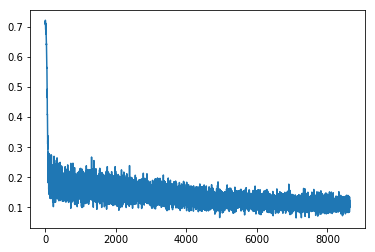

In [537]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [538]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        items, users, targets = data
        outputs = R(items, users)
        predicted = torch.round(outputs.data)
        keep_one = targets == 1
        total += 1
        correct += sum(predicted[keep_one] == targets[keep_one]).item() / targets[targets == 1].size(0)
        # total += targets.size(0)
        # correct += (predicted == targets).sum(dim=0).float()

print((correct / total))

0.04081026097339817


In [540]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        items, users, targets = data
        outputs = R(items, users)
        predicted = torch.round(outputs.data)
        total += targets.size(0)
        correct += (predicted == targets).sum(dim=0).float()

<BarContainer object of 3722 artists>

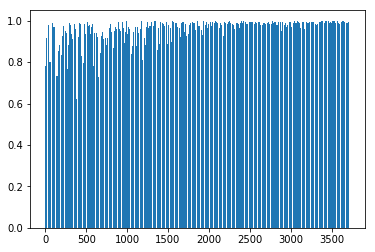

In [541]:
plt.bar(np.arange(ratings_df.movieId.max() + 1), (correct / total).numpy())

In [486]:
keep_one = targets == 1
predicted[keep_one] == targets[keep_one] 

tensor([1, 1, 0,  ..., 1, 1, 1], dtype=torch.uint8)

In [479]:
sum((predicted == targets)[0]) / 

tensor(211, dtype=torch.uint8)

In [515]:
torch.round(R(items, users))

tensor([[1., 0., 1.,  ..., 0., 0., 0.]], grad_fn=<RoundBackward>)

In [539]:
targ[targets == 1]

3722

## Recommender description based

In [218]:
imdbId2mId = {i + 1: m for i, m in enumerate(links_df.imdbId)}

In [219]:
import itertools

In [220]:
l = [c.split('|') for c in list(movies_df.genres)]

In [32]:
%timeit a = [item for sublist in l for item in sublist]
%timeit b = list(itertools.chain.from_iterable(l))

948 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
646 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [221]:
import numpy as np
genres = list(np.unique(list(itertools.chain.from_iterable(l))))

In [222]:
genre_oh = np.array([[int(genres[i] in j) for i in range(20)] for j in movies_df.genres])

In [80]:
id = 4
description[imdbId2mId[id+1]], movies_df.title[id]

('George Banks must deal not only with the pregnancy of his daughter, but also with the unexpected pregnancy of his wife.',
 'Father of the Bride Part II (1995)')

In [114]:
## rule to keep only some movies
a = ratings_df.movieId.value_counts()
b = set(a[a.between(5, 50)].index)
c = ratings_df.query("movieId in @b")

In [223]:
r_df = pd.DataFrame({
    'title': [movies_df.title[i] for i in range(1000)],
    'description': [description[imdbId2mId[i+1]] for i in range(1000)]
})

In [235]:
contentMovie_df = pd.merge(r_df, pd.DataFrame(genre_oh[:100], columns=genres), right_index=True, left_index=True)

In [6]:
DATA_FOLDER = '../data'
FILE = 'train.csv'

In [237]:
contentMovie_df.drop(columns='title', inplace=True)
contentMovie_df.to_csv(os.path.join(DATA_FOLDER, FILE))

In [7]:
contentMovie_df = pd.read_csv(os.path.join(DATA_FOLDER, FILE))

In [113]:
desc = list(contentMovie_df.description)
desc = [d 
        if type(d) is not np.float 
        else 'Nothing' 
        for d in desc]

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [76]:
spacy_sw = spacy.lang.en.stop_words.STOP_WORDS
def fct(doc):
    return ' '.join([w.lemma_ for w in doc 
            if w.lemma_ not in spacy_sw and 
            not w.is_punct and 
            w.tag_ != 'VBN'
           ])

In [117]:
docs = nlp.pipe(desc)

In [118]:
clean_desc = [fct(doc) for doc in docs]

In [239]:
from torchtext.data import Field
tokenize = lambda x: x.split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)
LABEL = Field(sequential=False, use_vocab=False)

In [240]:
from torchtext.data import TabularDataset
tv_datafields = [("id", None), # we won't be needing the id, so we pass in None as the field
                 ("description", TEXT)] + [(g, LABEL) for g in genres]

In [241]:
trn = TabularDataset.splits(
        path="../data", # the root directory where the data lies
        train='train.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=tv_datafields)[0]

In [242]:
TEXT.build_vocab(trn)

In [243]:
TEXT.vocab.freqs.most_common(10)

[('a', 163),
 ('the', 112),
 ('to', 82),
 ('and', 64),
 ('of', 57),
 ('in', 47),
 ('his', 41),
 ('an', 28),
 ('is', 26),
 ('with', 24)]

In [244]:
trn[0].description[:3]

['a', 'cowboy', 'doll']

In [245]:
from torchtext.data import Iterator, BucketIterator

In [246]:
train_iter = BucketIterator(
        trn, # we pass in the datasets we want the iterator to draw data from
        batch_size=64,
        sort_key=lambda x: len(x.comment_text), # the BucketIterator needs to be told what function it should use to group the data.
        sort_within_batch=False,
        repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)

In [247]:
batch = next(train_iter.__iter__()); batch


[torchtext.data.batch.Batch of size 36]
	[.description]:[torch.LongTensor of size 40x36]
	[.(no genres listed)]:[torch.LongTensor of size 36]
	[.Action]:[torch.LongTensor of size 36]
	[.Adventure]:[torch.LongTensor of size 36]
	[.Animation]:[torch.LongTensor of size 36]
	[.Children]:[torch.LongTensor of size 36]
	[.Comedy]:[torch.LongTensor of size 36]
	[.Crime]:[torch.LongTensor of size 36]
	[.Documentary]:[torch.LongTensor of size 36]
	[.Drama]:[torch.LongTensor of size 36]
	[.Fantasy]:[torch.LongTensor of size 36]
	[.Film-Noir]:[torch.LongTensor of size 36]
	[.Horror]:[torch.LongTensor of size 36]
	[.IMAX]:[torch.LongTensor of size 36]
	[.Musical]:[torch.LongTensor of size 36]
	[.Mystery]:[torch.LongTensor of size 36]
	[.Romance]:[torch.LongTensor of size 36]
	[.Sci-Fi]:[torch.LongTensor of size 36]
	[.Thriller]:[torch.LongTensor of size 36]
	[.War]:[torch.LongTensor of size 36]
	[.Western]:[torch.LongTensor of size 36]

In [248]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'description', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

In [249]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y
    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)

In [250]:
train_dl = BatchWrapper(train_iter, "description", genres)

In [251]:
next(train_dl.__iter__())

(tensor([[1053,    2,    2,  ...,    9,  356,   56],
         [ 304,  339, 1173,  ...,   78,  578,  245],
         [   4,   46,   13,  ...,  203,  489,  140],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]),
 tensor([[0., 1., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [302]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [312]:
range(0)

range(0, 0)

In [313]:
class SimpleBiLSTMBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim=300,
                 spatial_dropout=0.05, recurrent_dropout=0.1, 
                 num_linear=2):
        super().__init__() # don't forget to call this!
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=2, 
                               dropout=recurrent_dropout)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, 
                                                hidden_dim))
        self.linear_layers = nn.ModuleList(self.linear_layers)
        self.predictor = nn.Linear(hidden_dim, 20)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        preds = self.predictor(feature)
        return self.sigmoid(preds)

In [314]:
em_sz = 64
nh = 250
nl = 3
model = SimpleBiLSTMBaseline(nh, emb_dim=em_sz, num_linear=nl); model

SimpleBiLSTMBaseline(
  (embedding): Embedding(1234, 64)
  (encoder): LSTM(64, 250, num_layers=2, dropout=0.1)
  (linear_layers): ModuleList(
    (0): Linear(in_features=250, out_features=250, bias=True)
    (1): Linear(in_features=250, out_features=250, bias=True)
  )
  (predictor): Linear(in_features=250, out_features=20, bias=True)
  (sigmoid): Sigmoid()
)

#### Training

In [315]:
import tqdm

In [316]:
opt = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.9))
loss_func = nn.BCEWithLogitsLoss()

In [317]:
epochs = 10
losses = []

In [318]:
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() # turn on training mode
    for x, y in tqdm.tqdm(train_dl): # thanks to our wrapper, we can intuitively iterate over our data!
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        
        running_loss += loss.data.item() * x.size(0)
        losses.append(loss.item())
    epoch_loss = running_loss / len(trn)
    
    # calculate the validation loss for this epoch
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))

100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.56it/s]


Epoch: 1, Training Loss: 0.7837


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


Epoch: 2, Training Loss: 0.7509


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch: 3, Training Loss: 0.6148


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch: 4, Training Loss: 0.5972


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


Epoch: 5, Training Loss: 0.5961


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.27it/s]


Epoch: 6, Training Loss: 0.5892


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch: 7, Training Loss: 0.5961


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


Epoch: 8, Training Loss: 0.5614


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.39it/s]


Epoch: 9, Training Loss: 0.5892


100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.46it/s]


Epoch: 10, Training Loss: 0.5961


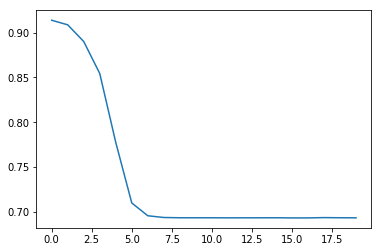

In [319]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(losses)